## Данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools
import lightgbm as lgbm


contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

In [2]:
contract.info()
contract.drop(columns='MonthlyCharges').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,7488-MXJIV,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5174,3875,4171,2365,11


In [3]:
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7488-MXJIV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [2]:
personal.info()
personal.drop(columns='SeniorCitizen').describe()

In [5]:
phone.info()
phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7488-MXJIV,No
freq,1,3390


In [6]:
# Собираем таблицу
data = contract.merge(personal, how='left', on='customerID')
data = data.merge(internet, how='left', on='customerID')
data[internet.columns] = data[internet.columns].fillna('No')
data = data.merge(phone, how='left', on='customerID')
data[phone.columns] = data[phone.columns].fillna('No phone')

data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d', errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Целевой признак
data['Churn'] = data['EndDate'].fillna(0).agg(lambda x: 1 if x!=0 else 0)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

,MonthlyCharges,TotalCharges,SeniorCitizen,Churn
count,7043.000000,7032.000000,7043.000000,7043.000000
mean,64.761692,2283.300441,0.162147,0.265370
std,30.090047,2266.771362,0.368612,0.441561
min,18.250000,18.800000,0.000000,0.000000
25%,35.500000,401.450000,0.000000,0.000000
50%,70.350000,1397.475000,0.000000,0.000000
75%,89.850000,3794.737500,0.000000,1.000000
max,118.750000,8684.800000,1.000000,1.000000


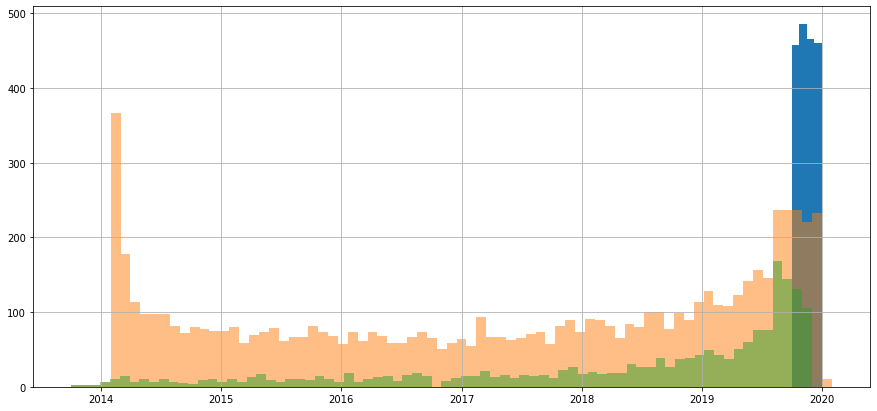

In [7]:
data[data['Churn']==1]['EndDate'].hist(bins=4, figsize=(15, 7))
data['BeginDate'].hist(bins=77, alpha=0.5)
data[data['Churn']==1]['BeginDate'].hist(bins=76, alpha=0.5)

Оранжевое это сколько абонентов подключилось за месяц, Синее сколько ушло. Зеленое это дата подключения тех кто ушел.

Заметно, что относительно новенькие стали чаще уходить.

Поскольку информация актуальна на 01.02.2020, значит можно сделать признак длительности контракта через timedelta с этим днем. Это полностью оправдывает удаление объектов, которые описывают совсем свежих клиентов, которые подключились только в этом месяце (01.02.2020)

In [8]:
# Данные актуальны на 01.02.2020
horizon = pd.Timestamp('20200201')

# считаем длительность контракта
data['duration'] = round((data['EndDate'].fillna(horizon) - 
                              data['BeginDate']).astype('timedelta64[D]') / 30)

# убираем свежак
data = data.drop(data[data['BeginDate']==horizon].index)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

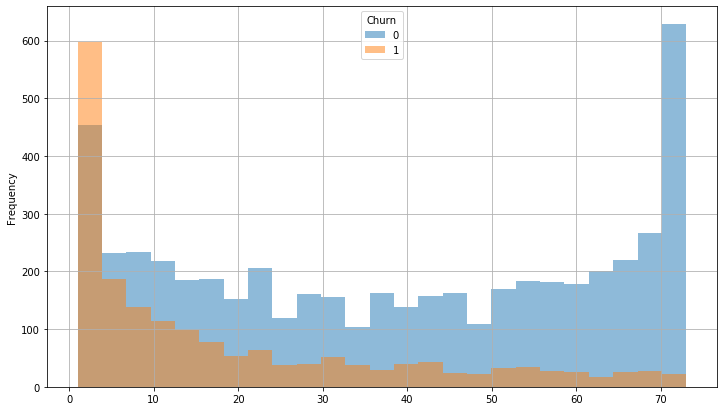

In [9]:
data.pivot_table(index=data.index, columns='Churn', 
                 values='duration').plot.hist(bins=25, alpha=0.5, figsize=(12, 7), grid=True)

И здесь видно, что уходят те, у кого контракт не долгий.

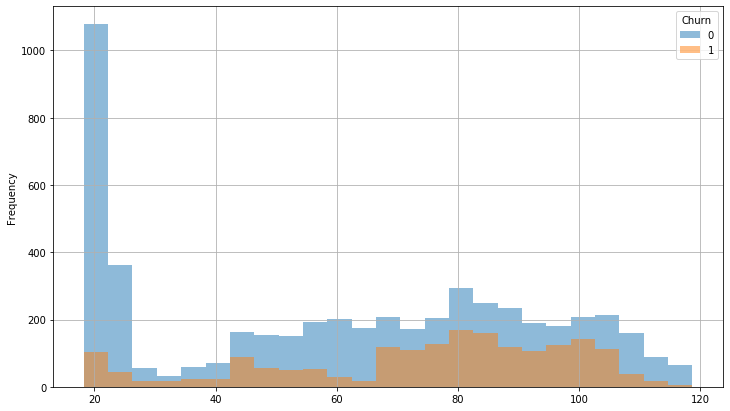

In [10]:
data.pivot_table(index=data.index, columns='Churn', 
                 values='MonthlyCharges').plot.hist(bins=25, alpha=0.5, figsize=(12, 7), grid=True)

Можно предположить, что довольно большое количество ушедших имели большую месячную плату.

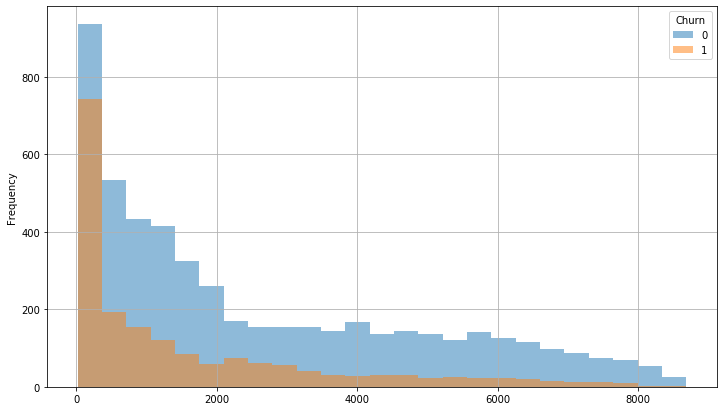

In [11]:
data.pivot_table(index=data.index, columns='Churn', 
                 values='TotalCharges').plot.hist(bins=25, alpha=0.5, figsize=(12, 7), grid=True)

И здесь опять видна зависимость, что уходят клиенты которые не долго были с нашей компанией.

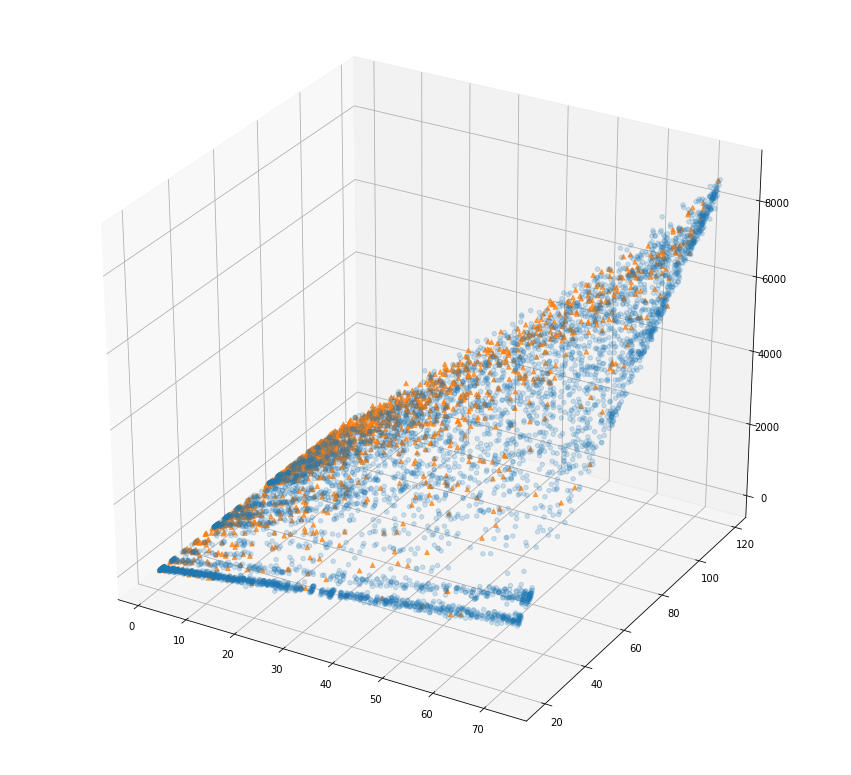

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Пространство признаков

x = data[data['Churn'] == 0]['duration']
y = data[data['Churn'] == 0]['MonthlyCharges']
z = data[data['Churn'] == 0]['TotalCharges']

x1 = data[data['Churn'] == 1]['duration']
y1 = data[data['Churn'] == 1]['MonthlyCharges']
z1 = data[data['Churn'] == 1]['TotalCharges']

fig = plt.figure(figsize=(15, 14))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, alpha=0.2)
ax.scatter(x1, y1, z1, marker='^', alpha=0.7)

### Подготовка данных:

In [5]:
# Убиаем лишние признаки
data = data.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

# Dummy преобразование категориальных признаков
data = pd.get_dummies(data, dtype='int64')

# создадим новый признак общее кол-во сервисов клиента
data['total_serv'] = (data[['OnlineSecurity_Yes', 'OnlineBackup_Yes', 
                           'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 
                           'StreamingMovies_Yes']] == 1).sum(axis=1) + \
                        (data[['MultipleLines_No phone']] == 0).count(axis=1) + \
                        (data[['InternetService_No']] == 0).count(axis=1)

data.info()
data.describe()

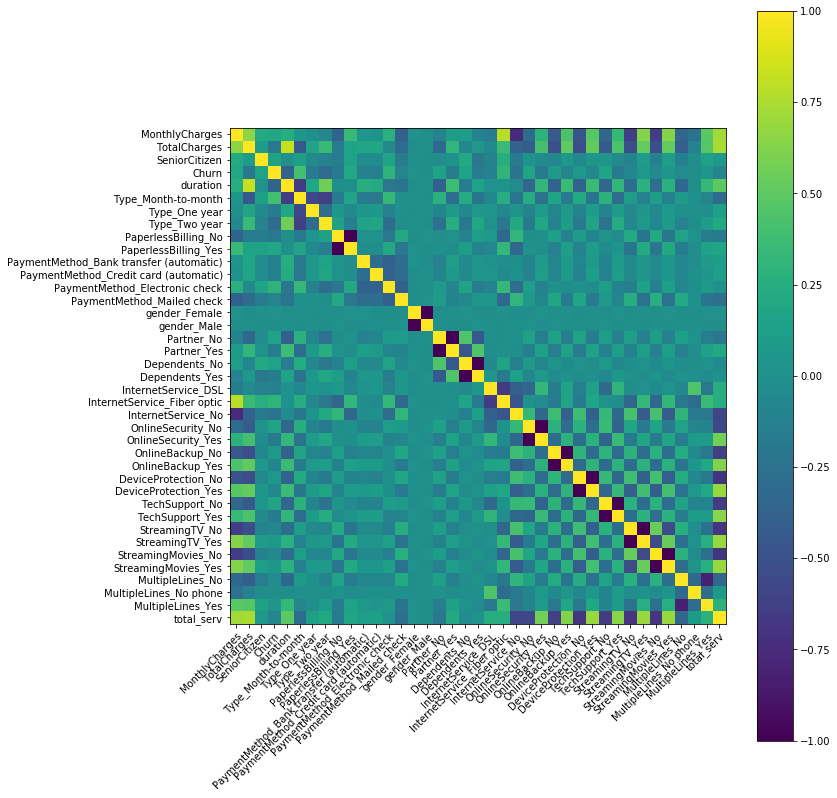

In [14]:
# Корреляция признаков

def corr_map(data):
    
    label = list(data.columns)
    dt = data.corr()

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(dt)

    ax.set_xticks(np.arange(len(label)))
    ax.set_yticks(np.arange(len(label)))
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)

    cbar = ax.figure.colorbar(im, ax=ax)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    fig.tight_layout()
    plt.show()
    

corr_map(data)

['PaperlessBilling_Yes', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']


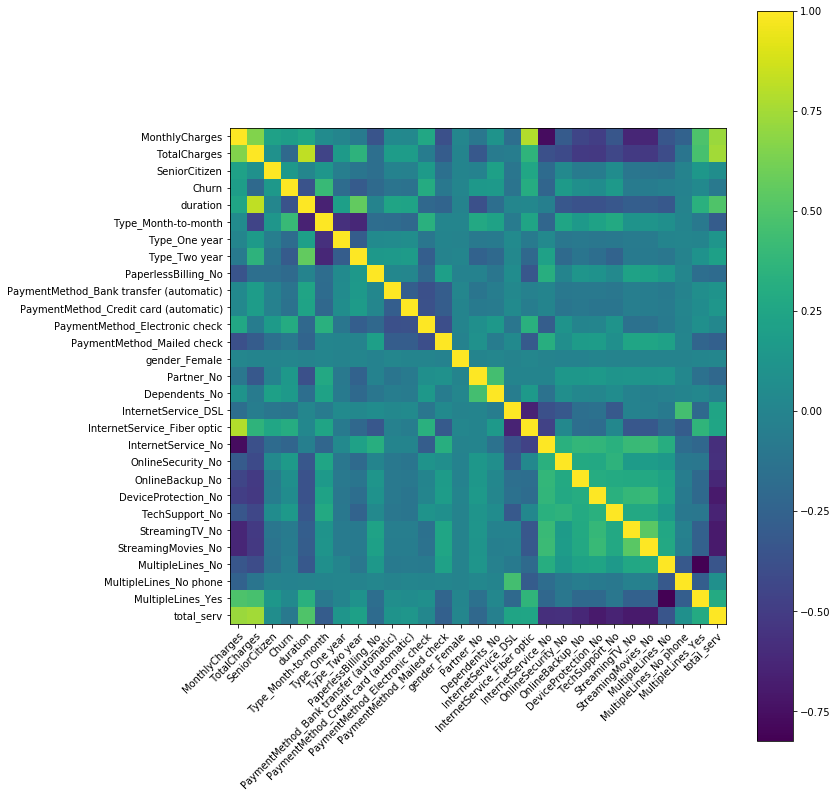

In [15]:
# Удаляем мультиколлениарные признаки
triangle = data.corr().where(np.triu(np.ones(data.corr().shape), k=1).astype(np.bool))
to_drop = [col for col in data.columns if any(triangle[col] < -0.9)]
print(to_drop)

data = data.drop(columns=to_drop)
corr_map(data)

In [16]:
# Признаки
feat = data.drop(['Churn'], axis=1)
# Целевой признак
target = data['Churn']

feat.info()
target.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           7032 non-null   float64
 1   TotalCharges                             7032 non-null   float64
 2   SeniorCitizen                            7032 non-null   int64  
 3   duration                                 7032 non-null   float64
 4   Type_Month-to-month                      7032 non-null   int64  
 5   Type_One year                            7032 non-null   int64  
 6   Type_Two year                            7032 non-null   int64  
 7   PaperlessBilling_No                      7032 non-null   int64  
 8   PaymentMethod_Bank transfer (automatic)  7032 non-null   int64  
 9   PaymentMethod_Credit card (automatic)    7032 non-null   int64  
 10  PaymentMethod_Electronic check           7032 no

count    7032.000000
mean        0.265785
std         0.441782
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn, dtype: float64

Поскольку будет использоваться кросс валидация, данные разбиваются только на трейн и тест и тут же масштабируем:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(feat, target, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=y_train.index, columns=feat.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=y_test.index, columns=feat.columns)

for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(4922, 28)
(4922,)
(2110, 28)
(2110,)


## Тест моделей
----

In [18]:
# Графики кривой и матрица
def auc_matrix_plot(proba, y_test, pred):
    
    auc = roc_auc_score(y_test, proba[:, 1])
    acc = accuracy_score(pred, y_test)
    matrix = confusion_matrix(y_test, pred)
    
    proba_one_valid = proba[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_one_valid)
    label = ['0', '1']
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(fpr, tpr)
    axs[1].imshow(matrix, cmap='bone')
    
    axs[0].plot([0, 1], [0, 1], linestyle='--')
    axs[0].set_title('ROC-кривая')
    
    axs[1].set_xticks(np.arange(len(label)))
    axs[1].set_yticks(np.arange(len(label)))
    axs[1].set_xticklabels(label)
    axs[1].set_yticklabels(label)
    
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")
    
    for i in range(len(label)):
        for j in range(len(label)):
            text = axs[1].text(j, i, matrix[i, j],
                           ha="center", va="center", color='g', fontsize=24)    
    
    axs[1].set_title("Confusion matrix")
    fig.tight_layout()
    
    plt.show()
    
    return {'ROC_AUC':auc, 'Accuracy':acc}


# Веса logit
def logit_weights(model, X):
    
    weight = pd.Series(
        model.coef_[0], 
        index=X.columns.values).sort_values(
        ascending=False)
    
    weight.plot(kind='bar', figsize=(10, 5), grid=True)
    
    return weight


# Решетчатый поиск параметров
def search_best_param(model, param_grid, X, y, test, y_test):
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', 
                               n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y)
    
    best_estim = grid_search.best_estimator_
    
    print('Лучшая модель:\n', best_estim, '\n')
    print('Val AUC_ROC: ', grid_search.best_score_)
    print('Test AUC_ROC: ', grid_search.score(test, y_test))
    print('Test accuracy: ', accuracy_score(best_estim.predict(test), y_test))
    
    auc_matrix_plot(best_estim.predict_proba(test), y_test, best_estim.predict(test))
    
    cv_reslt = pd.DataFrame(grid_search.cv_results_
                           ).sort_values(by='rank_test_score')
    
    return cv_reslt[
        [col for col in cv_reslt.columns 
         if 'param_' in col] + 
        ['mean_train_score', 'std_train_score', 'mean_test_score',  'std_test_score']
                   ], best_estim

### Logistic Regression

In [19]:
logit_model = LogisticRegression(class_weight='balanced', 
                                 max_iter=1000, random_state=42)

param_logit = {'tol': [1e-3, 1e-4, 1e-5, 1e-6],
              'solver': ['lbfgs', 'liblinear'],
              'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10, 100]}

Лучшая модель:
 LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False) 

Val AUC_ROC:  0.8473565373848005
Test AUC_ROC:  0.8383846055588735
Test accuracy:  0.7393364928909952


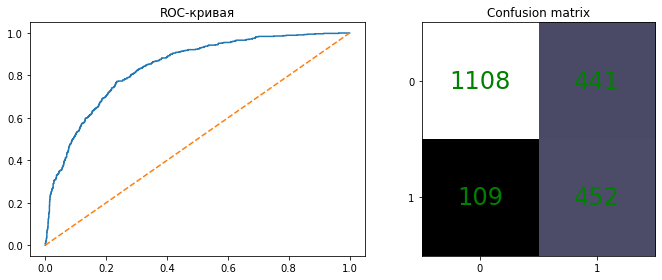

Wall time: 1min 6s


,param_C,param_penalty,param_solver,param_tol,mean_train_score,std_train_score,mean_test_score,std_test_score
60,10,l2,liblinear,0.001,0.851386,0.002921,0.847357,0.012260
61,10,l2,liblinear,0.0001,0.851396,0.002902,0.847328,0.012266
62,10,l2,liblinear,1e-05,0.851397,0.002902,0.847328,0.012264
63,10,l2,liblinear,1e-06,0.851397,0.002902,0.847327,0.012265
57,10,l2,lbfgs,0.0001,0.851397,0.002903,0.847327,0.012265


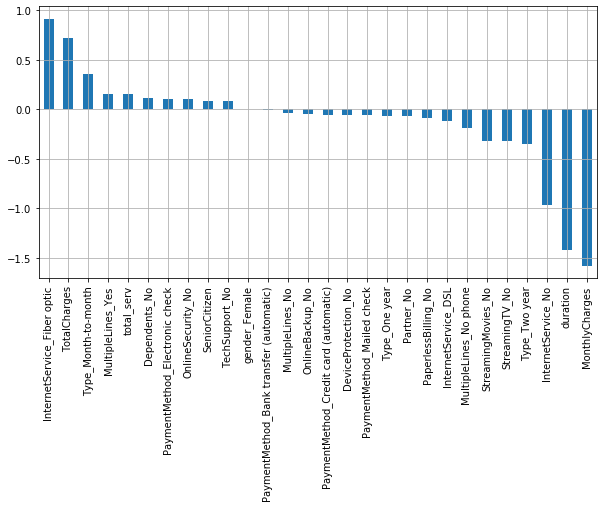

In [20]:
%%time

logit_result, best_logit = search_best_param(logit_model, param_logit, X_train, y_train, X_test, y_test)

weight = logit_weights(best_logit, X_train)
logit_result.head()

### SVM

In [21]:
model_svm = SVC(probability=True, class_weight='balanced', random_state=42)

param_svm = {'gamma': [0.001, 0.01, 0.1, 1, 10],
              'kernel': ['linear', 'rbf'],
              'C': [0.001, 0.01, 0.1, 1, 10]}

Лучшая модель:
 SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False) 

Val AUC_ROC:  0.8432614320146239
Test AUC_ROC:  0.8323879818962036
Test accuracy:  0.6867298578199053


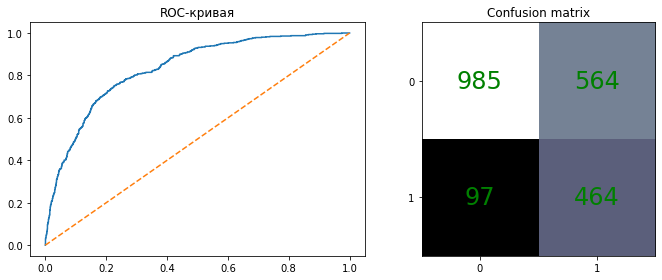

Wall time: 6min 9s


,param_C,param_gamma,param_kernel,mean_train_score,std_train_score,mean_test_score,std_test_score
10,0.01,0.001,linear,0.846197,0.003141,0.843261,0.012243
18,0.01,10,linear,0.846197,0.003141,0.843261,0.012243
16,0.01,1,linear,0.846197,0.003141,0.843261,0.012243
14,0.01,0.1,linear,0.846197,0.003141,0.843261,0.012243
12,0.01,0.01,linear,0.846197,0.003141,0.843261,0.012243


In [22]:
%%time

svm_result, best_svm = search_best_param(model_svm, param_svm, X_train, y_train, X_test, y_test)
svm_result.head()

### LightGBM и RandomizedGridCV 

In [23]:
# Поиск параметров, обучение и тест градиентного бустинга
def lgmb_model_test(X, y, param, X_test, y_test, n_iter, feat_imp=False):
    
    fit_params = {"early_stopping_rounds" : 50, 
                 "eval_metric" : 'binary', 
                 "eval_set" : [(X_test, y_test)],
                 'eval_names': ['valid'],
                 'verbose': 0,
                 'categorical_feature': 'auto'}
    
    model = lgbm.LGBMClassifier(random_state=42, silent=True, metric=None)
    search = RandomizedSearchCV(estimator=model, 
                                param_distributions=param, 
                                n_iter=n_iter,
                                scoring='accuracy', cv=5,
                                refit=True,
                                random_state=42,
                                verbose=True)

    search.fit(X, y, **fit_params)
    best_params = search.best_params_
    
    print('Лучшие параметры: ', best_params)
    
    # Обучаем модель найденными параметрами
    model = lgbm.LGBMClassifier(**best_params, objective='binary', 
                                random_state=42, metrics=None)
    model.fit(X, y)
    pred_lgbm = model.predict(X_test)
    proba = model.predict_proba(X_test)
    
    print('---------------------------------->')
    print('Test AUC_ROC:', roc_auc_score(y_test, proba[:, 1]))
    print('Test accuracy: ', accuracy_score(pred_lgbm, y_test))
    
    auc_matrix_plot(proba, y_test, pred_lgbm)
    
    if feat_imp==True:
        
        pd.DataFrame(
            model.feature_importances_, 
            index=X.columns).sort_values(by=0,
            ascending=False).plot(kind='bar', 
                                  title='feature importances',
                                  figsize=(10, 5), grid=True)
    
    return best_params, model


param_lgbm = {
    'learning_rate':     [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
    'n_estimators':      [100, 500, 1000, 2000, 3000, 5000],
    'num_leaves':        [i for i in range(5, 90, 5)], 
    'min_data_in_leaf':  [i for i in range(1, 100, 5)],
    'max_depth':         [-1, 3, 5, 7, 9, 12],
    'reg_alpha':         [0, 0.1, 1, 2, 5, 7, 10],
    'reg_lambda':        [0, 0.1, 1, 2, 5, 7, 10]
}

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  5.3min finished


Лучшие параметры:  {'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 3000, 'min_data_in_leaf': 81, 'max_depth': 3, 'learning_rate': 0.2}
---------------------------------->
Test AUC_ROC: 0.8016539910171476
Test accuracy:  0.7691943127962085


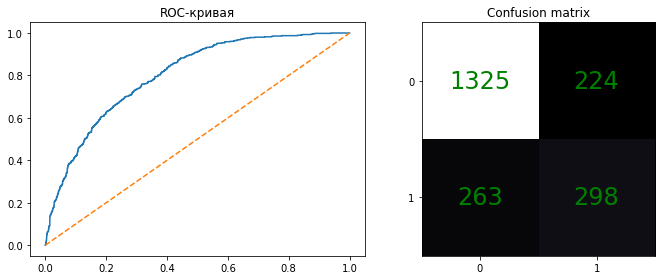

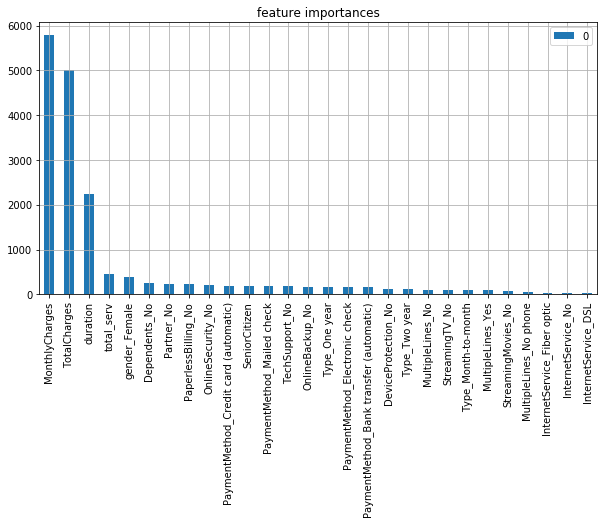

In [24]:
best_params, model = lgmb_model_test(X_train, y_train, 
                                     param_lgbm, 
                                     X_test, y_test, 
                                     n_iter=500, feat_imp=True)

## Отбор признаков
-----

Признаки можно попробовать отобрать с помощью весов логистической регрессии (ранее они были сохранены в переменной weight)

In [25]:
# в список включаю те, что считаю 100% нужно удалить.
to_drop = ['Partner_No', 'Dependents_No', 'gender_Female']

for col in weight.index:
    if (weight[col] < 0) & (weight[col] > -0.06):
        to_drop.append(col)

print('To drop:', to_drop)

X_sel_train = X_train.drop((to_drop), axis=1)
X_sel_test = X_test[X_sel_train.columns]

print()
print(X_sel_train.shape, X_sel_test.shape)

To drop: ['Partner_No', 'Dependents_No', 'gender_Female', 'PaymentMethod_Bank transfer (automatic)', 'MultipleLines_No', 'OnlineBackup_No', 'PaymentMethod_Credit card (automatic)', 'DeviceProtection_No', 'PaymentMethod_Mailed check']

(4922, 19) (2110, 19)


### Logistic Regression

Лучшая модель:
 LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False) 

Val AUC_ROC:  0.8481215388798393
Test AUC_ROC:  0.8400624173608642
Test accuracy:  0.7374407582938388


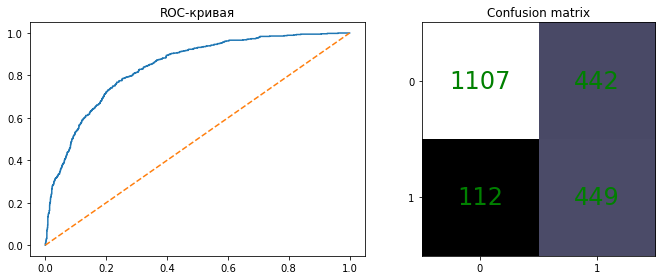

Wall time: 22.8 s


,param_C,param_penalty,param_solver,param_tol,mean_train_score,std_train_score,mean_test_score,std_test_score
68,100,l1,liblinear,0.001,0.850683,0.003083,0.848122,0.012787
60,10,l2,liblinear,0.001,0.850675,0.003106,0.848118,0.012687
58,10,l2,lbfgs,1e-05,0.850683,0.003100,0.848115,0.012664
56,10,l2,lbfgs,0.001,0.850683,0.003100,0.848115,0.012664
59,10,l2,lbfgs,1e-06,0.850683,0.003100,0.848115,0.012664


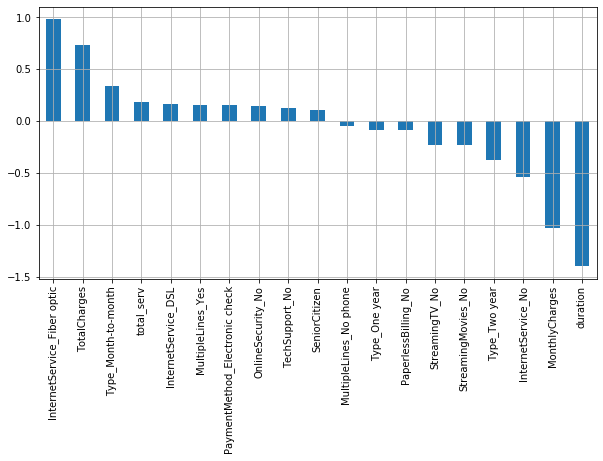

In [26]:
%%time
logit_result, best_sel_log = search_best_param(logit_model, param_logit, X_sel_train, y_train, X_sel_test, y_test)

logit_weights(best_sel_log, X_sel_train)
logit_result.head()

### SVM

Лучшая модель:
 SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False) 

Val AUC_ROC:  0.8437192116457688
Test AUC_ROC:  0.8331348267929745
Test accuracy:  0.6867298578199053


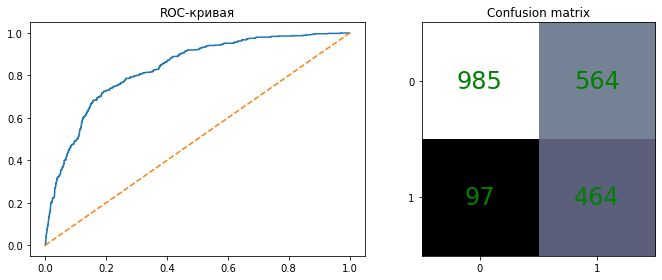

Wall time: 4min 19s


,param_C,param_gamma,param_kernel,mean_train_score,std_train_score,mean_test_score,std_test_score
10,0.01,0.001,linear,0.845549,0.003272,0.843719,0.013282
18,0.01,10,linear,0.845549,0.003272,0.843719,0.013282
16,0.01,1,linear,0.845549,0.003272,0.843719,0.013282
14,0.01,0.1,linear,0.845549,0.003272,0.843719,0.013282
12,0.01,0.01,linear,0.845549,0.003272,0.843719,0.013282


In [27]:
%%time
svm_result, best_svm_sel = search_best_param(model_svm, param_svm, X_sel_train, y_train, X_sel_test, y_test)
svm_result.head()

### LightGBM

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  5.1min finished


Лучшие параметры:  {'reg_lambda': 0, 'reg_alpha': 5, 'num_leaves': 5, 'n_estimators': 500, 'min_data_in_leaf': 1, 'max_depth': 7, 'learning_rate': 0.04}
---------------------------------->
Test AUC_ROC: 0.8438282878149206
Test accuracy:  0.8052132701421801


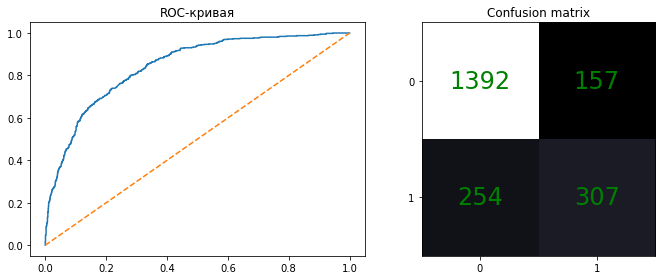

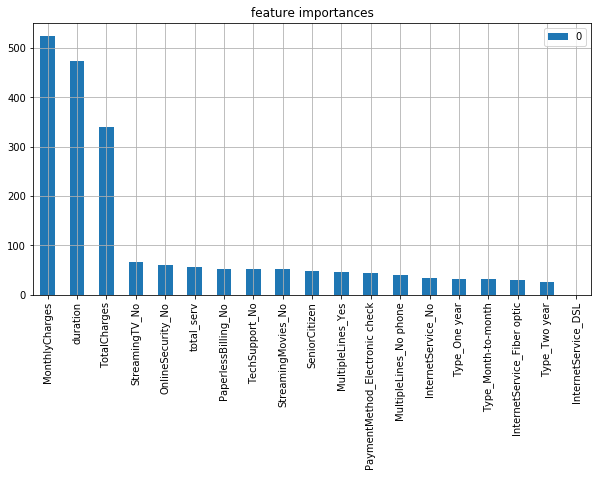

In [28]:
best_params, model_sel = lgmb_model_test(X_sel_train, y_train, 
                                         param_lgbm, 
                                         X_sel_test, y_test, 
                                         n_iter=500, feat_imp=True)

## Увеличение выборки
-----

Но с уменьшиным числом признаков.

In [29]:
from  sklearn.utils import shuffle

def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

X_up_train, y_up_train = upsample(X_sel_train, y_train, 7)
print(X_up_train.shape, y_up_train.shape)

(12770, 19) (12770,)


### Logistic Regression

Лучшая модель:
 LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

Val AUC_ROC:  0.848613927654432
Test AUC_ROC:  0.839945039580478
Test accuracy:  0.737914691943128


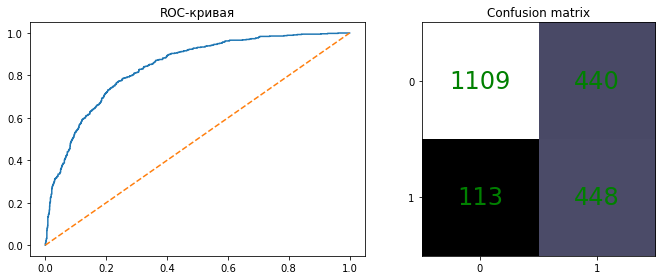

Wall time: 1min 47s


,param_C,param_penalty,param_solver,param_tol,mean_train_score,std_train_score,mean_test_score,std_test_score
45,1,l2,liblinear,0.0001,0.850568,0.000804,0.848614,0.003685
46,1,l2,liblinear,1e-05,0.850567,0.000805,0.848613,0.003684
41,1,l2,lbfgs,0.0001,0.850570,0.000806,0.848612,0.003685
42,1,l2,lbfgs,1e-05,0.850570,0.000806,0.848612,0.003685
43,1,l2,lbfgs,1e-06,0.850570,0.000806,0.848612,0.003685


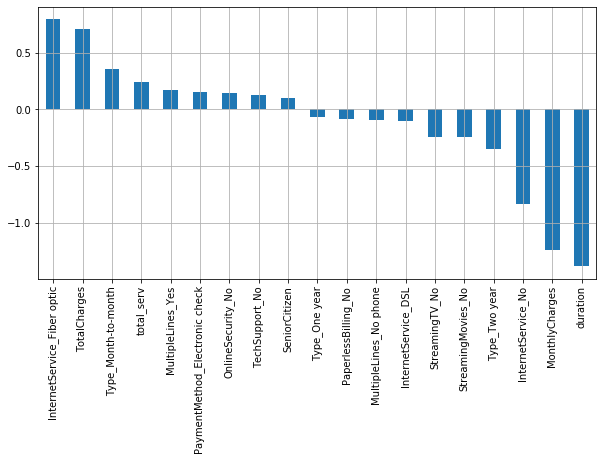

In [30]:
%%time

logit_result, best_up_log = search_best_param(logit_model, param_logit, X_up_train, y_up_train, X_sel_test, y_test)

logit_weights(best_up_log, X_up_train)
logit_result.head()

### LightGBM

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  7.2min finished


Лучшие параметры:  {'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 85, 'n_estimators': 5000, 'min_data_in_leaf': 1, 'max_depth': -1, 'learning_rate': 0.08}
---------------------------------->
Test AUC_ROC: 0.7913713522265531
Test accuracy:  0.7440758293838863


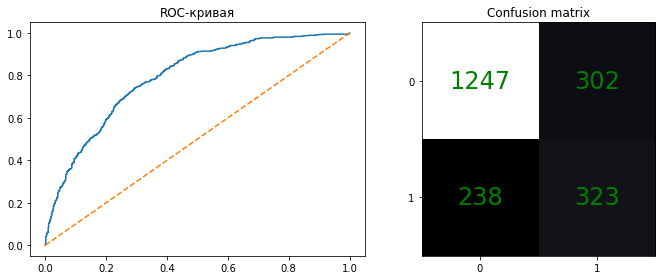

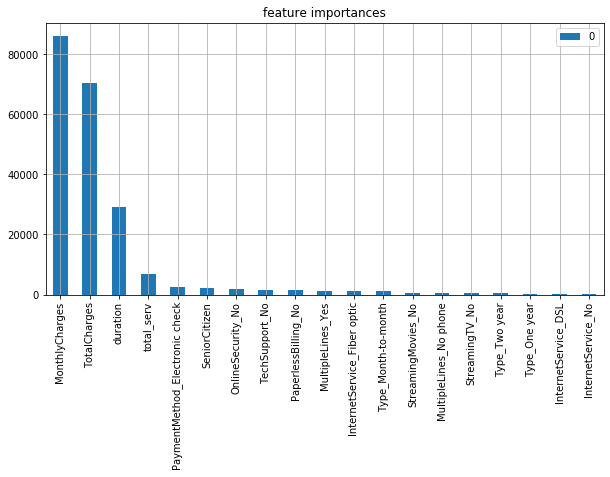

In [31]:
best_params, model_up = lgmb_model_test(X_up_train, y_up_train, 
                                        param_lgbm, 
                                        X_sel_test, y_test, 
                                        n_iter=200, feat_imp=True)

----------------------

В заключении

In [45]:
feat_new = feat.copy()

# год начала контракта
feat_new['begin_year'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d').dt.year

In [33]:
X_train_new, X_test_new, y_train, y_test = train_test_split(feat_new, target, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_new = pd.DataFrame(scaler.fit_transform(X_train_new), index=y_train.index, columns=feat_new.columns)
X_test_new = pd.DataFrame(scaler.transform(X_test_new), index=y_test.index, columns=feat_new.columns)

for i in [X_train_new, y_train, X_test_new, y_test]:
    print(i.shape)

(4922, 29)
(4922,)
(2110, 29)
(2110,)


Лучшая модель:
 LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

Val AUC_ROC:  0.8914721388589187
Test AUC_ROC:  0.8770087998812413
Test accuracy:  0.7772511848341233


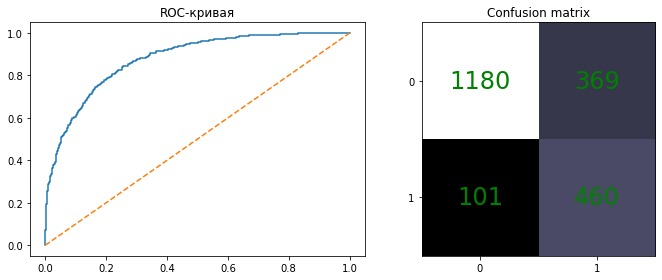

Wall time: 1min 8s


,param_C,param_penalty,param_solver,param_tol,mean_train_score,std_train_score,mean_test_score,std_test_score
53,10,l1,liblinear,0.0001,0.894916,0.002160,0.891472,0.008888
54,10,l1,liblinear,1e-05,0.894915,0.002160,0.891470,0.008913
55,10,l1,liblinear,1e-06,0.894915,0.002161,0.891464,0.008917
56,10,l2,lbfgs,0.001,0.894918,0.002165,0.891462,0.008901
57,10,l2,lbfgs,0.0001,0.894918,0.002165,0.891462,0.008901


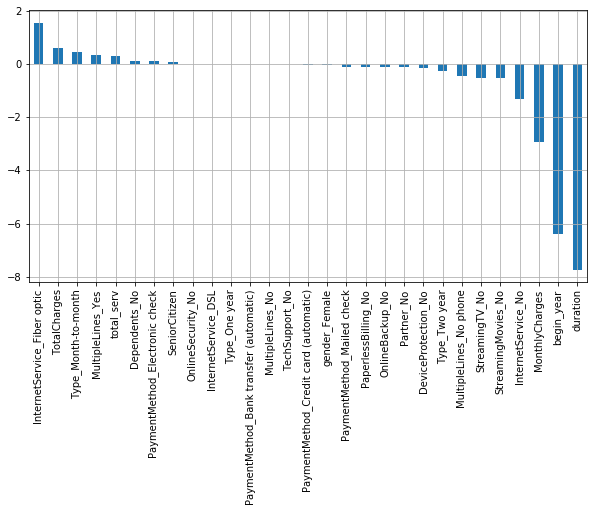

In [34]:
%%time

logit_result, best_new_log = search_best_param(logit_model, param_logit, X_train_new, y_train, X_test_new, y_test)

logit_weights(best_new_log, X_train_new)
logit_result.head()

Все же наверное это не правильно, использовать год начала контракта для этой модели, ведь так происходит утечка целевого признака, через 2 связанных признака год начала и продолжительность. Если к этому добавить еще и месяц вообще 1 получается.

# Отчет

Изначально у меня был какой-то план и я его придерживался.<br>
На самом деле была только одна идея попробовать сделать все в лоб, исследовать что получится и исходя из этих результатов дорабатывать.

И это мог бы быть хороший подход если бы я сразу додумался исследовать влияние признаков, а не параметров моделей. В результате я просто убил кучу времени на бессмысленный тьюнинг моделей. Десяти часовые пайпы выдавали, что нет ничего лучше контрольной ЛогРегрессии с минимальным тьюном.<br>
Вернувшись к изначальному предположению о неинформативности имеющихся признаков, было принято решение создавать новые. Так появились признаки кол-ва сервисов и продолжительность контракта. БУМ! 0.99 везде. Переобучил не иначе. Проблема оказалась в признаках месяца и года начала контракта вместе с его продолжительностью (код с признаком года оставил в конце на память). Начал удалять признаки, а затем и отбирать самые информативные для модели. Лучшим методом отбора признаков стал метод отбора по весам ЛогРегрессии.<br>
Для отбора из большего пространства признаков решил использовать все dummy признаки не удаляя первых. Появилась проблема мультиколлинеарности, которую пришлось решать проверяя признаки определенным порогом в треугольнике матрици корреляций.

Ключевым шагом в решении задачи считаю предобработку данных. Исследование влияния признаков, не просто их распределение, а именно совместное влияние.<br> 
Уверен, модель можно улучшить просто повозившись с имеющимися признаками, исследовав зависимости сделав новые более информативные признаки, а может просто категоризировав имеющиеся, можно добиться большего разделения точек классов в пространстве признаков. И как вариант, все же найти данные о трафике абонентов.

Итоговая модель зависит от задачи бизнеса, что будет приоритетней минимизировать ложно отрицательные/положительные ошибки или высокая точность определения класса 1 TruePositive. Компромисс между этим по идее и должна описывать ROC-AUC кривая. Поэтому лучшей моделью должен быть градиентный бустинг с уменьшеным пространством признаков.<br>
Вот ее результаты:

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  5.1min finished


Лучшие параметры:  {'reg_lambda': 0, 'reg_alpha': 5, 'num_leaves': 5, 'n_estimators': 500, 'min_data_in_leaf': 1, 'max_depth': 7, 'learning_rate': 0.04}
---------------------------------->
Test AUC_ROC: 0.8438282878149206
Test accuracy:  0.8052132701421801


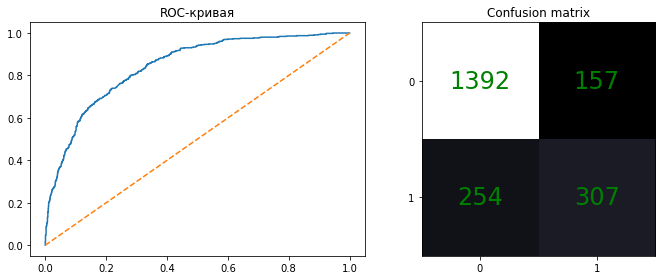

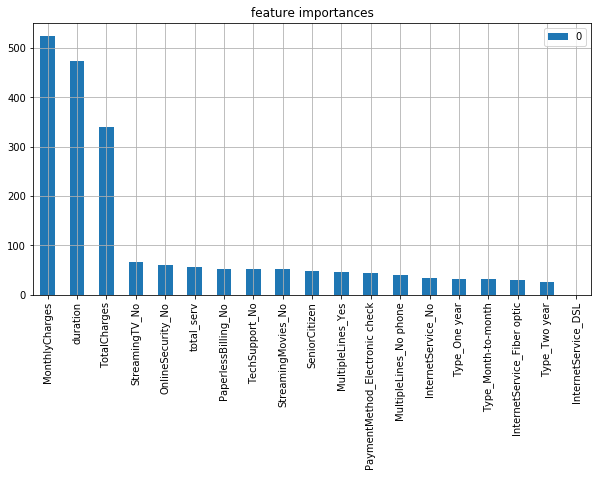

In [28]:
best_params, model_sel = lgmb_model_test(X_sel_train, y_train, 
                                         param_lgbm, 
                                         X_sel_test, y_test, 
                                         n_iter=500, feat_imp=True)